In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl

In [17]:
y = pd.read_csv('/Users/kris/Library/CloudStorage/OneDrive-Personal/Data science/applications of data science/assessment 3/ECG Data/y_labels.csv')
x = np.load('/Users/kris/Library/CloudStorage/OneDrive-Personal/Data science/applications of data science/assessment 3/ECG Data/x_data.npy')

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test= train_test_split(x, y, test_size = 0.25)

In [19]:
# print the shape of the training and holdout data
print('Training dataset: X_train=', x_train.shape, ', y_train', y_train.shape)
print('Testing dataset: X_test=', x_test.shape, ', y_test', y_test.shape)

Training dataset: X_train= (2380, 2000, 3) , y_train (2380, 1)
Testing dataset: X_test= (794, 2000, 3) , y_test (794, 1)


In [20]:
# further split the training into validation and training sets

x_train, x_val, y_train, y_val= train_test_split(x_train, y_train, test_size = 0.50)

In [21]:
x_tr_k = x_train.reshape((-1, 1,2000,3))
x_val_k = x_val.reshape((-1, 1,2000,3))

In [22]:
from tensorflow import keras
from keras.utils import to_categorical

# Assuming y_train and y_val are single-label categorical labels (not one-hot encoded)
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [23]:
y_train.shape

(1190, 2)

In [24]:
x_tr_k.shape


(1190, 1, 2000, 3)

In [26]:
# make a function to display metrics of chosen models and specify names of the models.

def display_metrics(models, model_names):
    for i, model in enumerate(models, start=1):
        max_train_accuracy = max(model.history['accuracy'])
        min_train_loss = min(model.history['loss'])
        max_val_accuracy = max(model.history['val_accuracy'])
        min_val_loss = min(model.history['val_loss'])

        print(f"Metrics for Model {model_names[i-1]}:")
        print(f"Max Training Accuracy: {max_train_accuracy:.3f}")
        print(f"Min Training Loss: {min_train_loss:.3f}")
        print(f"Max Validation Accuracy: {max_val_accuracy:.3f}")
        print(f"Min Validation Loss: {min_val_loss:.3f}")
        print()

In [27]:
# this step was to make a function to display learning curve plots for loss and accuracy,

def plot_learning_curves(models, model_names):

    colors = ['blue', 'red', 'green', 'orange', 'purple']  # List of colors for each model
    plt.figure(figsize=(14, 6))
    plt.suptitle(f'Learning Curves for the CNN using {model_names}', fontsize=16)

    for i, model in enumerate(models):
        history = model.history

        loss = history['loss']
        val_loss = history['val_loss']
        accuracy = history['accuracy']
        val_accuracy = history['val_accuracy']
        epochs = range(1, len(loss) + 1)
        color = colors[i % len(colors)]

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, loss, label=f'{model_names[i]} - Training Loss')
        plt.plot(epochs, val_loss,linestyle='dashed',color = color, label=f'{model_names[i]} - Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, accuracy, label=f'{model_names[i]} - Training Accuracy')
        plt.plot(epochs, val_accuracy,linestyle='dashed',color = color, label=f'{model_names[i]} - Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.grid(True)


    plt.tight_layout()
    plt.show()

In [28]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, LearningRateScheduler

def build_cnn(filters, optimizer, initial_lr, decay_rate, loss_function):
    # set the random state for consistency
    tf.random.set_seed(123)
    # clear the layer counting each run
    tf.keras.backend.clear_session()

    # Create the CNN model
    model = Sequential()

    # Convolutional layers
    for i, num_filters in enumerate(filters):
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, kernel_size=(5), input_shape=(1, 2000, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(1, 8)))

    # Flatten layer
    model.add(Flatten())

    # Output layer
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))

    # Define the learning rate schedule for exponential decay
    def learning_rate_schedule(epoch, lr):
        return lr / decay_rate**(epoch)

    # Compile the model
    optimizer = Nadam(learning_rate=initial_lr)
    model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        LearningRateScheduler(lambda epoch: learning_rate_schedule(epoch, initial_lr))
    ]

    return model, callbacks

In [29]:
import tensorflow as tf

# normal input for the build cnn function
filters = [32, 64, 128]  # Number of filters in each convolutional layer
optimizer = Nadam  # Optimizer
initial_lr = 0.10  # Initial learning rate
loss_function = 'categorical_crossentropy'  # Loss function

# list of decay rates too try
decay_rates = [3]
models = []
max_train_accuracies = []
max_val_accuracies = []
decay_used = []

for rate in decay_rates:
    # Create the model with current hyperparameters
    model, callbacks = build_cnn(filters, optimizer, initial_lr, decay_rate=rate, loss_function = loss_function)
   # fit the model with the training data and validate with the val data
    model_lr = model.fit(x_tr_k, y_train, validation_data=(x_val_k, y_val), batch_size=40,
                         epochs=20, callbacks=callbacks, verbose = 1)
    models.append(model_lr)

    # Compile accuracies for plotting with learning rate
    max_train_accuracy = max(model_lr.history['accuracy'])
    max_val_accuracy = max(model_lr.history['val_accuracy'])
    max_train_accuracies.append(max_train_accuracy)
    max_val_accuracies.append(max_val_accuracy)
    decay_used.append(str(rate))

Epoch 1/20
30/30 [==============================] - 7s 144ms/step - loss: 2.2080 - accuracy: 0.7277 - val_loss: 1.5793 - val_accuracy: 0.6487 - lr: 0.1000
Epoch 2/20
30/30 [==============================] - 5s 153ms/step - loss: 0.2411 - accuracy: 0.9134 - val_loss: 0.5526 - val_accuracy: 0.7563 - lr: 0.0333
Epoch 3/20
30/30 [==============================] - 5s 159ms/step - loss: 0.1343 - accuracy: 0.9504 - val_loss: 0.3350 - val_accuracy: 0.8597 - lr: 0.0111
Epoch 4/20
30/30 [==============================] - 5s 164ms/step - loss: 0.1139 - accuracy: 0.9630 - val_loss: 0.4156 - val_accuracy: 0.7933 - lr: 0.0037
Epoch 5/20
30/30 [==============================] - 5s 167ms/step - loss: 0.0959 - accuracy: 0.9723 - val_loss: 0.5263 - val_accuracy: 0.7387 - lr: 0.0012
Epoch 6/20
30/30 [==============================] - 5s 157ms/step - loss: 0.1073 - accuracy: 0.9664 - val_loss: 0.5782 - val_accuracy: 0.7294 - lr: 4.1152e-04
Epoch 7/20
30/30 [==============================] - 5s 160ms/step 

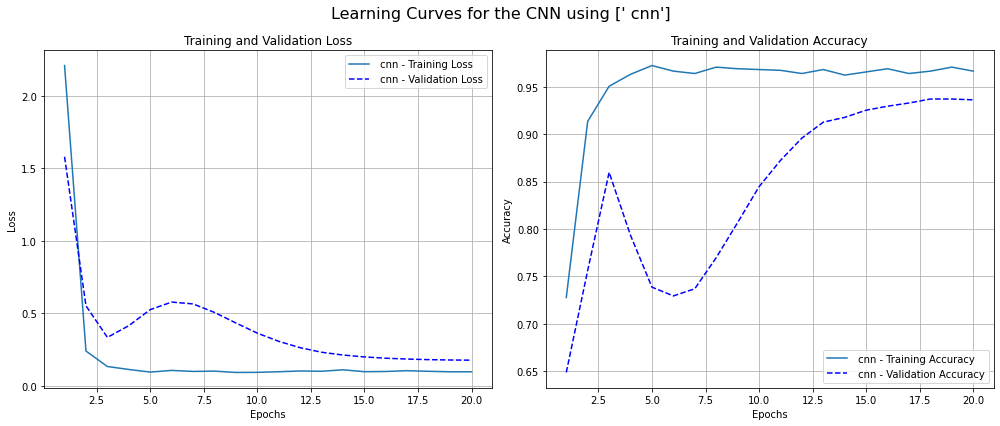

Metrics for Model  cnn:
Max Training Accuracy: 0.972
Min Training Loss: 0.093
Max Validation Accuracy: 0.937
Min Validation Loss: 0.178



In [30]:
models= [model_lr]
model_names= [' cnn']
plot_learning_curves(models, model_names)
display_metrics(models,model_names)

In [31]:
# prepare the  X test data

x_test_k = x_test.reshape((-1, 1,2000,3))

## fit on the untouched test data from the start.

Y_pred = model.predict(x_test_k)

25/25 [==============================] - 1s 26ms/step


In [32]:
# evaluate the model metrics

test_loss, test_accuracy = model.evaluate(x_test_k, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:',test_accuracy)

25/25 [==============================] - 1s 28ms/step - loss: 0.2048 - accuracy: 0.9282
Test Loss: 0.2048274576663971
Test Accuracy: 0.9282115697860718


In [33]:
model.save('my_cnn_model.h5')

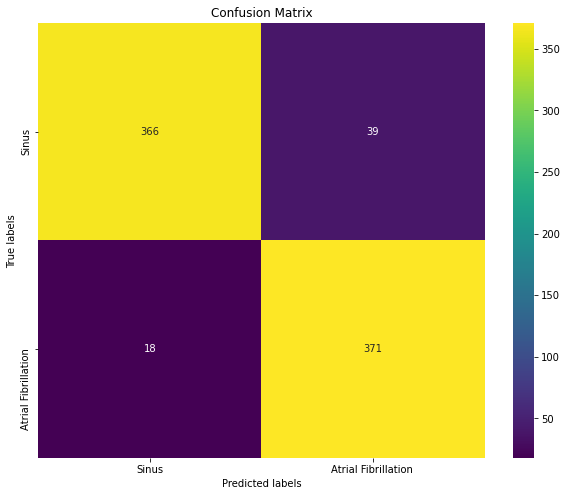

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the unique classes based on your class labels
unique_classes = np.unique(y_train)

# Define class names for visualization
class_names = ['Sinus', 'Atrial Fibrillation ']

# Assuming Y_pred contains predictions from your model
# Assuming y_test contains true labels
y_pred_labels = np.argmax(Y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [47]:
model = tf.keras.models.load_model('/Users/kris/Library/CloudStorage/OneDrive-Personal/Data science/applications of data science/assessment 3/ECG Data/my_cnn_model.h5')

In [60]:
import innvestigate
from tensorflow.keras.models import Model

# Remove the softmax layer from your model
model_without_softmax = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Create Analyzers
analyzer = innvestigate.create_analyzer("gradient", model_without_softmax)

In [64]:
model_without_softmax

In [61]:
relevance_scores = analyzer.analyze(x_val_k)

RecursionError: maximum recursion depth exceeded while calling a Python object